This notebook deviates slightly in how the class structure is built. This is done to aid clarity of NN architecture. In partucular insted of one class FlattenConsecutive, 3 are introduced -- RegroupInput, RegroupHidden and FlattenConsecutive.

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# Table of Contents
- **[Constants](#1)**
- **[Data prep](#2)**
- **[Main training funcs](#3)**
- **[Baseline training](#4)**
- **[Adjusting NN architecture](#5)**
    - [Result of context legth increase](#5-1)
    - [Toy example of matr multiplication with increased context length](#5-2)
    - [Fusing each 2 consecutive elements](#5-3)
    - [New Layer RegroupInput](#5-4)
    - [New Layer FlattenConsecutive](#5-5)
    - [Correction of BatchNorm](#5-6)
    - [New layer RegroupHidden, final arch](#5-7)
- **[Final training and demo](#6)**

<a name='1'></a>
# Constants

In [266]:
BLOCK_SIZE = 8
GROUP_SIZE = 2
HIDDEN_LAYER_SIZE = 200
EMBEDDING_SIZE = 10 
BATCH_SIZE = 32

<a name='2'></a>
# Data prep

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [7]:
# build the dataset

def build_dataset(words, block_size=BLOCK_SIZE, verbose=False):
     # context length: how many charachters do we 
    X, Y = [], []
    for w in words:

        if verbose: print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            if verbose: print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return {'X': X, 'Y': Y}

train_percent = 0.8
train_start_ix, train_end_ix = 0, int(train_percent * (len(words)))
eval_start_ix, eval_end_ix = train_end_ix+1, train_end_ix + int((len(words) - train_end_ix)/2)
test_start_ix, test_end_ix = eval_end_ix+1, len(words)-1
# eval_percent, test_percent = 1-train_percent/2,  1-train_percent/2; 

random.shuffle(words)
train_ds_dict = build_dataset(words=words[train_start_ix:train_end_ix], verbose=False)
train_X = train_ds_dict['X']; train_Y = train_ds_dict['Y']

eval_ds_dict = build_dataset(words=words[eval_start_ix:eval_end_ix], verbose=False)
eval_X = eval_ds_dict['X']; eval_Y = eval_ds_dict['Y']

test_ds_dict = build_dataset(words=words[test_start_ix:test_end_ix], verbose=False)
test_X = test_ds_dict['X']; test_Y = test_ds_dict['Y']

<a name='3'></a>
# Main training funcs

In [404]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
    
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean((0, 1), keepdim=True) # batch mean
            xvar = x.var((0, 1), keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class RegroupInput:
    
    def __init__(self, group_size):
        self.group_size = group_size
    
    def __call__(self, x):
        A, B = x.shape
        self.out = x.view(A, B//self.group_size, self.group_size)
        return self.out

    def parameters(self):
        return []

class RegroupHidden:
    
    def __init__(self, group_size):
        self.group_size = group_size
    
    def __call__(self, x):
        n, B, C = x.shape
        self.out = x.view(n, B//self.group_size, C*self.group_size)
        if self.out.shape[1] <= 1:
            self.out = self.out.squeeze(1)
        return self.out

    def parameters(self):
        return []

class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class FlattenLastDims:
  
    def __init__(self, group_s):
#         self.emb_s = emb_s
        self.group_s = group_s

    def __call__(self, x):
        # number of examples; Block size// Group size; Embedding size*group size = A; B; D*C
        x_shape = x.shape #A, B, C, D
        A, B, C, D = x_shape
        self.out = x.view(A, B, D*C)
        return self.out

    def parameters(self):
        return []

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [371]:
def forward_pass(X, layers):
#     emb = C[X] # embed the characters into vectors
#     x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        X = layer(X)
    return X

def back_pass(parameters, nll_loss, lr=.1):
#     for layer in layers:
#         layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None
    nll_loss.backward()
  
    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    return parameters 

@torch.no_grad()
def eval_model(model, train_X, train_Y, eval_X, eval_Y, test_X, test_Y):
    
    # evaluating on the whole training dataset
    logits = model(train_X)
    nll_loss_train = F.cross_entropy(logits, train_Y)
    
    # evaluating on the eval dataset
    logits = model(eval_X)
    nll_loss_eval = F.cross_entropy(logits, eval_Y)
    
    # evaluating on the test dataset
    logits = model(test_X)
    nll_loss_test = F.cross_entropy(logits, test_Y)
    
    return {'train': nll_loss_train.item(), 'eval': nll_loss_eval.item(), 'test': nll_loss_test.item()}

def generate_name_nn(num_names, layers):
    '''
    Here we start with first row because it contains first letters of names, 
    sample a letter (or collumn), 
    this letter gives us the number or a row to sample next from.
    This is repeated until the end token is sampled.
    '''
    
    out = []
    for cnt in range(num_names):
        this_name = []
        context = [0]*BLOCK_SIZE
        for _ in range(50):
            
            #forward pass
#             print(torch.tensor(context))
            in_tmp = torch.unsqueeze(torch.tensor(context), 0)
            logits = model(in_tmp)
            probs = F.softmax(logits, dim=1)
            
            #sampling
            ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
            context = context[1:] + [ix]
            this_name.append(itos[ix])
            
            if ix == 0:
                 break
        out.append(''.join(this_name)[:-1])
    return out

<a name='4'></a>
# Baseline training

In [10]:
torch.manual_seed(42);

In [11]:
layers = [
    Embedding(len(chars), EMBEDDING_SIZE),
    Flatten(),
    Linear(EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear(          HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12070


In [118]:
Embedding(len(chars), EMBEDDING_SIZE)(Xb).shape

torch.Size([4, 8, 10])

In [133]:
max_steps = 200000
batch_size = BATCH_SIZE
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
#     logits = forward_pass(Xb, layers)
    logits = model(Xb)
    nll_loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    lr = .1 if i<=1e5 else 0.01
    parameters = back_pass(parameters, nll_loss, lr=lr)
    
#     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {nll_loss.item():.4f}')
    lossi.append(nll_loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#     if i >= 5000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3123
  10000/ 200000: 2.3394
  20000/ 200000: 2.2165
  30000/ 200000: 1.9454
  40000/ 200000: 1.8885
  50000/ 200000: 2.3406
  60000/ 200000: 2.3610
  70000/ 200000: 2.0238
  80000/ 200000: 2.6097
  90000/ 200000: 1.9053
 100000/ 200000: 2.0646
 110000/ 200000: 2.1519
 120000/ 200000: 2.1795
 130000/ 200000: 2.0472
 140000/ 200000: 2.5666
 150000/ 200000: 2.3182
 160000/ 200000: 2.1262
 170000/ 200000: 2.0645
 180000/ 200000: 2.2795
 190000/ 200000: 1.8285


In [134]:
eval_model(model, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 2.0642905235290527,
 'eval': 2.1047487258911133,
 'test': 2.1168038845062256}

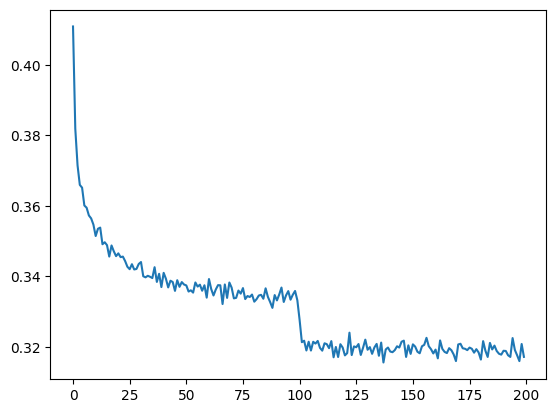

In [135]:
"""
The step change is reduction of the learning rate
"""
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(1))

In [136]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

generate_name_nn(30, layers)

<a name='5'></a>
# Adjusting NN architecture

<a name='5-1'></a>
## Result of context legth increase

First we increase the length of the context from 3 letters to 8 and show how the result improves

In [382]:
BLOCK_SIZE = 8
GROUP_SIZE = 2

In [383]:
train_percent = 0.8
train_start_ix, train_end_ix = 0, int(train_percent * (len(words)))
eval_start_ix, eval_end_ix = train_end_ix+1, train_end_ix + int((len(words) - train_end_ix)/2)
test_start_ix, test_end_ix = eval_end_ix+1, len(words)-1
# eval_percent, test_percent = 1-train_percent/2,  1-train_percent/2; 

random.shuffle(words)
train_ds_dict = build_dataset(words=words[train_start_ix:train_end_ix], verbose=False, block_size=BLOCK_SIZE)
train_X = train_ds_dict['X']; train_Y = train_ds_dict['Y']

eval_ds_dict = build_dataset(words=words[eval_start_ix:eval_end_ix], verbose=False, block_size=BLOCK_SIZE)
eval_X = eval_ds_dict['X']; eval_Y = eval_ds_dict['Y']

test_ds_dict = build_dataset(words=words[test_start_ix:test_end_ix], verbose=False, block_size=BLOCK_SIZE)
test_X = test_ds_dict['X']; test_Y = test_ds_dict['Y']

In [42]:
layers = [
    Embedding(len(chars), EMBEDDING_SIZE),
    Flatten(),
    Linear(EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear(          HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True# checking results with larger context
max_steps = 200000
batch_size = BATCH_SIZE
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
#     logits = forward_pass(Xb, layers)
    logits = model(Xb)
    nll_loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    lr = .1 if i<=1e5 else 0.01
    parameters = back_pass(parameters, nll_loss, lr=lr)
    
#     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {nll_loss.item():.4f}')
    lossi.append(nll_loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#     if i >= 5000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

22070


In [43]:
# checking results with larger context
max_steps = 200000
batch_size = BATCH_SIZE
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
#     logits = forward_pass(Xb, layers)
    logits = model(Xb)
    nll_loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    lr = .1 if i<=1e5 else 0.01
    parameters = back_pass(parameters, nll_loss, lr=lr)
    
#     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {nll_loss.item():.4f}')
    lossi.append(nll_loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#     if i >= 5000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3102
  10000/ 200000: 2.0538
  20000/ 200000: 2.0249
  30000/ 200000: 2.2013
  40000/ 200000: 1.5770
  50000/ 200000: 1.9699
  60000/ 200000: 1.7364
  70000/ 200000: 2.2824
  80000/ 200000: 2.5678
  90000/ 200000: 2.0673
 100000/ 200000: 1.8027
 110000/ 200000: 2.2835
 120000/ 200000: 2.4028
 130000/ 200000: 2.0468
 140000/ 200000: 2.0384
 150000/ 200000: 2.0227
 160000/ 200000: 1.8412
 170000/ 200000: 1.8774
 180000/ 200000: 2.4253
 190000/ 200000: 1.7204


In [44]:
eval_model(model, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 1.9330434799194336,
 'eval': 2.0206751823425293,
 'test': 2.0360805988311768}

In [45]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

generate_name_nn(30, layers)

['canisu',
 'darrin',
 'azairel',
 'gillyngton',
 'renaly',
 'loice',
 'hajmell',
 'sadi',
 'cayleigh',
 'lamil',
 'vanell',
 'jaxaide',
 'konaliz',
 'goham',
 'laylon',
 'keymar',
 'tyru',
 'leanne',
 'taiden',
 'zachara',
 'azlel',
 'jamae',
 'wille',
 'brenley',
 'kahau',
 'anarioba',
 'loviah',
 'whil',
 'giyon',
 'carmin']

In [28]:
train_X.shape[1]

8

<a name='5-2'></a>
## Toy example of matr multiplication with increased context length

In [424]:
ix = torch.randint(0, train_X.shape[0], (4,))
Xb, Yb = train_X[ix], train_Y[ix]
logits = model(Xb)
# print(Xb.shape)
Xb

tensor([[ 0,  0,  0,  2, 15, 15, 11,  5],
        [ 0,  0,  0,  5,  4, 23,  9, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 10, 15, 18,  9,  5]])

In [94]:
model.layers[0]

In [95]:
"""
In the embedding layer, the input 2d tensor turns into a 3d tensor, 
because each number that represents one character gets a new NN weight representation with a legth of 10.
So the shape from previous layer is changed as follows: 
[n, B] -> [n, B, C]
where n --number of examples, B -- block size, C -- embedding length
"""
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [55]:
model.layers[1]

In [53]:
'''
he shape from previous layer is changed as follows: 
[n, B, C] -> [n, B*C]
where n --number of examples, B -- block size, C -- embedding length
'''
model.layers[1].out.shape

torch.Size([4, 80])

In [57]:
model.layers[2]

In [54]:
model.layers[2].out.shape

torch.Size([4, 200])

In [63]:
#imitating mult operation in linear layer, no bias
(torch.randn([4,80]) @ torch.randn([80, 200])).shape

torch.Size([4, 200])

In [64]:
#we can get the same shape of mult product if there is more than two dimensions in the left tensor
#dimensions before last in the left tesor are left unchanged
(torch.randn([4, 5, 10, 80]) @ torch.randn([80, 200])).shape

torch.Size([4, 5, 10, 200])

<a name='5-3'></a>
## Fusing each 2 consecutive elements

In [67]:
# we use it to introduce new "batch" dimension into the input tensor by pairing 
# each two consecutive numbers into pairs like so
# 9, 2, 4, 1, 4, 2, 6, 3 -> (9, 2), (4, 1), (4, 2), (6, 3)
torch.tensor(((9, 2), (4, 1), (4, 2), (6, 3))).shape

torch.Size([4, 2])

In [115]:
#so this is the shate or tensor we would expect to be in training now 
grouped_tuple = (
    ((9, 2), (4, 1), (4, 2), (6, 3)), 
    ((9, 2), (4, 1), (4, 2), (6, 3)), 
    ((9, 2), (4, 1), (4, 2), (6, 3)),
    ((9, 2), (4, 1), (4, 2), (6, 3))
)

grouped_tensor = torch.tensor(grouped_tuple)
grouped_tensor

tensor([[[9, 2],
         [4, 1],
         [4, 2],
         [6, 3]],

        [[9, 2],
         [4, 1],
         [4, 2],
         [6, 3]],

        [[9, 2],
         [4, 1],
         [4, 2],
         [6, 3]],

        [[9, 2],
         [4, 1],
         [4, 2],
         [6, 3]]])

In [116]:
# the shape of this tensor then is the 
# [number of examples X number of groups X number of elements in each group ]
grouped_tensor.shape

torch.Size([4, 4, 2])

So instead of initial shape of (4, 8) we get the shape of (4, 4, 2), that is
(n, B) -> (n, B//T, T)
where n - number of examples, B - block size and T - group size

<a name='5-4'></a>
## New Layer RegroupInput

Now if previously the embedding layer received a tensor of the shape [n, B], 
now it should receive the shape (n, B//T, T). For this purpose a new RegroupInput layer is introduced.

In [300]:
layers = [
    RegroupInput(2),
    Embedding(len(chars), EMBEDDING_SIZE),
    Flatten(),
    Linear(EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear(          HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22070


In [301]:
new_logits = model(Xb)

In [302]:
model.layers[0]

In [303]:
# The regroup layer works as expected changing the shape 
# [n, B] -> [n, B//T, T]
# where n --number of examples, B -- block size, T -- group size
model.layers[0].out.shape

torch.Size([4, 4, 2])

In [304]:
model.layers[1]

In [305]:
#The embedding layer works as expected
# [n, B//T, T] -> [n, B//T, T, C]
# where n --number of examples, B -- block size, C -- embedding length, T -- group size
model.layers[1].out.shape

torch.Size([4, 4, 2, 10])

In [306]:
# The flattern layer now changes the shape like so:
# [n, B//T, T, C] -> [n, B//T*T*C]
# It effectively flattens out our groups of 2. We want to keep those groups, 
# and only stack the 10 values of embedding for each group into 1 dimension
# So, in case the input is 4 dimensional, it should change the shape like so:
# [n, B//T, T, C] -> [n, B//T, C*T]
# where n --number of examples, B -- block size, C -- embedding length, T -- group size
model.layers[2].out.shape

torch.Size([4, 80])

<a name='5-5'></a>
## New Layer FlattenConsecutive

In [308]:
# Along with introduction of new layer FlattenConsecutive we also change the value of fan_in parameter for the
# following Linear layer from EMBEDDING_SIZE * BLOCK_SIZE to GROUP_SIZE * EMBEDDING_SIZE

layers = [
    Regroup(2),
    Embedding(len(chars), EMBEDDING_SIZE),
    FlattenConsecutive(2),
    Linear(GROUP_SIZE*EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear(          HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

10070


In [309]:
new_new_logits = model(Xb)

In [310]:
model.layers[2]

In [311]:
#The embedding layer works as expected changin shape as follows
# [n, B//T, T, C] -> [n, B//T, T*C]
# where n --number of examples, B -- block size, C -- embedding length, T -- group size
model.layers[2].out.shape

torch.Size([4, 4, 20])

In [157]:
model.layers[3]

In [312]:
#The linear layer works as expected, only changing the value of the last dimension
model.layers[3].out.shape

torch.Size([4, 4, 200])

In [313]:
model.layers[4]

<a name='5-6'></a>
## Correction of BatchNorm

In [314]:
# Even though the batch normalisation layer works fine, 
# but it only normalises values on first dimension, 
# whereas we have one extra dimensions which needs to be normalised as well
model.layers[4].out.shape

torch.Size([4, 4, 200])

In [316]:
# We've corrected batchnorm 
layers = [
    Regroup(GROUP_SIZE),
    Embedding(len(chars), EMBEDDING_SIZE),
    FlattenConsecutive( GROUP_SIZE),
    Linear(GROUP_SIZE*EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    Linear(HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

10070


In [317]:
model(Xb);

In [318]:
for layer in model.layers:
    print(layer.out.shape, layer)

torch.Size([4, 4, 2]) <__main__.Regroup object at 0x15c2d6050>
torch.Size([4, 4, 2, 10]) <__main__.Embedding object at 0x15c2d68c0>
torch.Size([4, 4, 20]) <__main__.FlattenConsecutive object at 0x15c2d5c30>
torch.Size([4, 4, 200]) <__main__.Linear object at 0x15c2d52a0>
torch.Size([4, 4, 200]) <__main__.BatchNorm1d object at 0x15c247ca0>
torch.Size([4, 4, 200]) <__main__.Tanh object at 0x15c245f90>
torch.Size([4, 4, 27]) <__main__.Linear object at 0x15c2450c0>


<a name='5-7'></a>
## New layer RegroupHidden, final arch

In [293]:
"""
We see that the final layer output has 3 dimensions instead of expected 2. 
To correct this we could insert the regrouping layer that would group the 3 dimensional input into 
groups of GROUP_SIZE = 2 unless the horizontal (or second) dimension is 1, in which case it should be squeezed out.
We need to do this operation twice to reach 2 dimensinal output.

Additionaly, in order to achieve the target architecture, where at each layer grouping or 2 elements 
is passed into the next layer where new activation is applied to the grouping, 
we need to add out linear and activation layers as well.
"""

torch.Size([32, 4, 27])

In [420]:
# We've added layers and separated regrouping for input layer and hidden layers, 
# adjusted fan_in parameters for linear layers

layers = [
#     input formatting
    RegroupInput(GROUP_SIZE),
    Embedding(len(chars), EMBEDDING_SIZE),
    FlattenLastDims( GROUP_SIZE),
    
#     1st layer group
    Linear(GROUP_SIZE*EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, bias=False), 
    BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    RegroupHidden(GROUP_SIZE),
    
#     2nd layer group
    Linear(GROUP_SIZE*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), 
    BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
    RegroupHidden(GROUP_SIZE),
    
#     3rd layer group
    Linear(GROUP_SIZE*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), 
    BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),

#     output layer 
    Linear(HIDDEN_LAYER_SIZE,        len(chars), bias=False)
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

170870


In [421]:
model(Xb);

In [422]:
Xb.shape

torch.Size([4, 8])

In [423]:
for layer in model.layers:
    print(layer.out.shape, layer)

torch.Size([4, 4, 2]) <__main__.RegroupInput object at 0x16a22c280>
torch.Size([4, 4, 2, 10]) <__main__.Embedding object at 0x16a22d330>
torch.Size([4, 4, 20]) <__main__.FlattenLastDims object at 0x16a22d4e0>
torch.Size([4, 4, 200]) <__main__.Linear object at 0x16a22dc60>
torch.Size([4, 4, 200]) <__main__.BatchNorm1d object at 0x15fda5ff0>
torch.Size([4, 4, 200]) <__main__.Tanh object at 0x1633e9ab0>
torch.Size([4, 2, 400]) <__main__.RegroupHidden object at 0x1633e80a0>
torch.Size([4, 2, 200]) <__main__.Linear object at 0x16a22ee60>
torch.Size([4, 2, 200]) <__main__.BatchNorm1d object at 0x1629801f0>
torch.Size([4, 2, 200]) <__main__.Tanh object at 0x16a22dbd0>
torch.Size([4, 400]) <__main__.RegroupHidden object at 0x16a22e3e0>
torch.Size([4, 200]) <__main__.Linear object at 0x16a22ff70>
torch.Size([4, 200]) <__main__.BatchNorm1d object at 0x16a22e020>
torch.Size([4, 200]) <__main__.Tanh object at 0x16a22c0d0>
torch.Size([4, 27]) <__main__.Linear object at 0x16a22eb30>


<a name='6'></a>
# Final training and demo

In [399]:
train_percent = 0.8
train_start_ix, train_end_ix = 0, int(train_percent * (len(words)))
eval_start_ix, eval_end_ix = train_end_ix+1, train_end_ix + int((len(words) - train_end_ix)/2)
test_start_ix, test_end_ix = eval_end_ix+1, len(words)-1
# eval_percent, test_percent = 1-train_percent/2,  1-train_percent/2; 

random.shuffle(words)
train_ds_dict = build_dataset(words=words[train_start_ix:train_end_ix], verbose=False, block_size=BLOCK_SIZE)
train_X = train_ds_dict['X']; train_Y = train_ds_dict['Y']

eval_ds_dict = build_dataset(words=words[eval_start_ix:eval_end_ix], verbose=False, block_size=BLOCK_SIZE)
eval_X = eval_ds_dict['X']; eval_Y = eval_ds_dict['Y']

test_ds_dict = build_dataset(words=words[test_start_ix:test_end_ix], verbose=False, block_size=BLOCK_SIZE)
test_X = test_ds_dict['X']; test_Y = test_ds_dict['Y']

In [400]:
# checking results with larger context
max_steps = 300000
batch_size = BATCH_SIZE
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
#     logits = forward_pass(Xb, layers)
    logits = model(Xb)
    nll_loss = F.cross_entropy(logits, Yb) # loss function

#     # backward pass
#     lr = .1 if i<=1e5 else 0.01
    if i < 1e5:
        lr = .1
    elif 1e5 <= i <= 2e5: 
        lr = .01
    elif i > 2e5: 
        lr = .005
    parameters = back_pass(parameters, nll_loss, lr=lr)
    
#     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {nll_loss.item():.4f}')
    lossi.append(nll_loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
#     if i >= 5000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 300000: 3.2873
  10000/ 300000: 2.1967
  20000/ 300000: 2.3047
  30000/ 300000: 2.0206
  40000/ 300000: 2.1656
  50000/ 300000: 2.5337
  60000/ 300000: 2.1068
  70000/ 300000: 1.7759
  80000/ 300000: 1.7481
  90000/ 300000: 2.1350
 100000/ 300000: 1.6586
 110000/ 300000: 1.8397
 120000/ 300000: 1.7824
 130000/ 300000: 1.4188
 140000/ 300000: 1.7714
 150000/ 300000: 1.6486
 160000/ 300000: 1.5574
 170000/ 300000: 2.1540
 180000/ 300000: 1.9783
 190000/ 300000: 1.6553
 200000/ 300000: 1.5494
 210000/ 300000: 1.9203
 220000/ 300000: 1.5948
 230000/ 300000: 1.8362
 240000/ 300000: 2.0442
 250000/ 300000: 2.1139
 260000/ 300000: 1.7553
 270000/ 300000: 1.9364
 280000/ 300000: 1.2931
 290000/ 300000: 1.6623


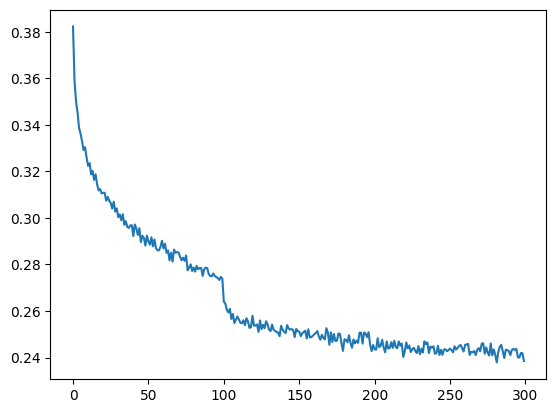

In [401]:
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(1))

In [402]:
eval_model(model, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 1.7379601001739502,
 'eval': 2.0182316303253174,
 'test': 1.9910467863082886}

In [403]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

generate_name_nn(30, layers)

['ramyn',
 'bexton',
 'abrianna',
 'kaylan',
 'adalni',
 'ar',
 'jazaye',
 'lilya',
 'quina',
 'aze',
 'maryce',
 'adif',
 'carsyn',
 'denia',
 'martin',
 'deannes',
 'sedie',
 'cristiano',
 'amaurie',
 'neida',
 'bryser',
 'tamari',
 'izzy',
 'zymariah',
 'anade',
 'emona',
 'nouphija',
 'philippeus',
 'hageng',
 'aradiada']